# Imports

In [1]:
import itertools
import os
import sys

import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy.signal
import scipy.signal
import sklearn.isotonic
import sklearn.model_selection
import sklearn.preprocessing
from matplotlib import pyplot as plt

try:
    import batteryanalytics
except ModuleNotFoundError as ie:
    sys.path.append( os.path.join(os.path.abspath(""), "../") )
    import batteryanalytics
from batteryanalytics import utils as ba_utils
from batteryanalytics.nn import CNN

from IPython.core.display import display, HTML, Image

# Parameters

In [2]:
basename = "mechanical_loading_data.csv.gz"
dirname = "../data"

window = 150
horizon = 300

# features = ["2000 Pounds [Pounds]", "Voltage [V]", "Temperature [C]"]
# features = ["2000 Pounds [Pounds]", "Voltage [V]"]
features = [
    "2000 Pounds [Pounds]", "Voltage [V]",
    "2000 Pounds [Pounds] (gradient 1)", "Voltage [V] (gradient 1)",
]
target = "Temperature [C]"

n_epochs = 10
training_filters = ["none", "savgol", "isotonic_regression"]
n_filters_list = [
    [8,4,2,1]
]
kernel_sizes = [
    [2,2,2,2]
]
hidden_dims = [
    [32,32],
    [64,64],
]
transfers = ["relu"]
n_models = 5

# Function Definitions

In [3]:
def suppress_stdout(func):
    import functools
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        from contextlib import redirect_stdout
        with open(os.devnull, "w") as fp:
            with redirect_stdout(fp):
                value = func(*args, **kwargs)
        return value
    return wrapper

# Data Loading

In [4]:
filename = os.path.join(dirname, basename)
raw_df = pd.read_csv(filename, header=[0,1,2], index_col=0, compression="gzip")
raw_df.info(verbose=True)
with pd.option_context("display.max_rows", 10, "display.max_columns", None):
    display(raw_df)
    display(raw_df.describe())

<class 'pandas.core.frame.DataFrame'>
Float64Index: 30115 entries, 0.0 to 3011.4
Data columns (total 315 columns):
 #   Column                                                    Dtype  
---  ------                                                    -----  
 0   (500 mAh 1, 20 SOC, 2000 Pounds [Pounds])                 float64
 1   (500 mAh 1, 20 SOC, Voltage [V])                          float64
 2   (500 mAh 1, 20 SOC, Temperature [C])                      float64
 3   (500 mAh 1, 20 SOC, 2000 Pounds [Pounds] (gradient 1))    float64
 4   (500 mAh 1, 20 SOC, Voltage [V] (gradient 1))             float64
 5   (500 mAh 1, 20 SOC, Temperature [C] (gradient 1))         float64
 6   (500 mAh 1, 20 SOC, 2000 Pounds [Pounds] (savgol 1))      float64
 7   (500 mAh 1, 20 SOC, Voltage [V] (savgol 1))               float64
 8   (500 mAh 1, 20 SOC, Temperature [C] (savgol 1))           float64
 9   (500 mAh 1, 40 SOC, 2000 Pounds [Pounds])                 float64
 10  (500 mAh 1, 40 SOC, Voltage 

500 mAh 1                              \
                         20 SOC                               
           2000 Pounds [Pounds] Voltage [V] Temperature [C]   
Time [Sec]                                                    
0.0                         NaN         NaN         23.6820   
0.1                    0.715723    3.745728         23.6810   
0.2                    0.562354    3.745422         23.6800   
0.3                    0.408984    3.745117         23.6815   
0.4                    0.357861    3.745728         23.6830   
...                         ...         ...             ...   
3011.0                      NaN         NaN             NaN   
3011.1                      NaN         NaN             NaN   
3011.2                      NaN         NaN             NaN   
3011.3                      NaN         NaN             NaN   
3011.4                      NaN         NaN             NaN   

                                                                       \
                                                                        
           2000 Pounds [Pounds] (gradient 1) Voltage [V] (gradient 1)   
Time [Sec]                                                              
0.0                                      NaN                      NaN   
0.1                                      NaN                      NaN   
0.2                                -1.533691                -0.003052   
0.3                                -1.022461                 0.001526   
0.4                                 1.278076                 0.001526   
...                                      ...                      ...   
3011.0                                   NaN                      NaN   
3011.1                                   NaN                      NaN   
3011.2                                   NaN                      NaN   
3011.3                                   NaN                      NaN   
3011.4                                   NaN                      NaN   

                                                                         \
                                                                          
           Temperature [C] (gradient 1) 2000 Pounds [Pounds] (savgol 1)   
Time [Sec]                                                                
0.0                             -0.0100                             NaN   
0.1                             -0.0100                             NaN   
0.2                              0.0025                             NaN   
0.3                              0.0150                             NaN   
0.4                             -0.0225                             NaN   
...                                 ...                             ...   
3011.0                              NaN                             NaN   
3011.1                              NaN                             NaN   
3011.2                              NaN                             NaN   
3011.3                              NaN                             NaN   
3011.4                              NaN                             NaN   

                                                              \
                                                               
           Voltage [V] (savgol 1) Temperature [C] (savgol 1)   
Time [Sec]                                                     
0.0                           NaN                   0.004307   
0.1                           NaN                   0.004255   
0.2                           NaN                   0.004202   
0.3                           NaN                   0.004150   
0.4                           NaN                   0.004097   
...                           ...                        ...   
3011.0                        NaN                        NaN   
3011.1                        NaN                        NaN   
3011.2                        NaN                        NaN   
3011.3                

500 mAh 1                                \
                    20 SOC                                 
      2000 Pounds [Pounds]   Voltage [V] Temperature [C]   
count         13458.000000  13458.000000    14333.000000   
mean           -125.284466      0.391926       27.662665   
std              37.747535      1.105976        6.976679   
min            -335.571680     -0.064392       23.606000   
25%            -129.954785      0.000610       24.059000   
50%            -124.229004      0.001831       24.282000   
75%            -122.030713      0.021515       26.273000   
max               1.635938      3.747864       48.749000   

                                                                  \
                                                                   
      2000 Pounds [Pounds] (gradient 1) Voltage [V] (gradient 1)   
count                      13456.000000             13456.000000   
mean                          -0.090309                -0.002784   
std                            6.702231                 0.101666   
min                          -35.530518                -8.872986   
25%                           -1.150269                -0.004578   
50%                            0.000000                 0.000000   
75%                            1.022461                 0.003815   
max                          480.045410                 0.358582   

                                                                    \
                                                                     
      Temperature [C] (gradient 1) 2000 Pounds [Pounds] (savgol 1)   
count                 14332.000000                    13360.000000   
mean                      0.000213                       -0.090956   
std                       0.190304                        1.981501   
min                      -0.945000                       -6.292359   
25%                      -0.040000                       -0.015448   
50%                      -0.005000                        0.017292   
75%                       0.022500                        0.047735   
max                       2.060000                       27.145238   

                                                                              \
                                                                      40 SOC   
      Voltage [V] (savgol 1) Temperature [C] (savgol 1) 2000 Pounds [Pounds]   
count           13360.000000               14284.000000         14329.000000   
mean               -0.002803                   0.000224          -117.228450   
std                 0.029667                   0.136085            39.437245   
min                -0.467504                  -0.207136          -345.080566   
25%                -0.000150                  -0.011964          -121.468359   
50%                -0.000025                  -0.002430          -114.106641   
75%                 0.000029                   0.001370          -111.959473   
max                 0.000741                   1.581676             2.198291   

                                                                       \
                                                                        
        Voltage [V] Temperature [C] 2000 Pounds [Pounds] (gradient 1)   
count  14329.000000    15257.000000                      14327.000000   
mean       0.432463       28.652413                         -0.078110   
std        1.122405        8.973171                          6.127025   
min       -0.059509       23.577000                        -51.378662   
25%        0.006409       23.989500                         -1.150269   
50%        0.010376       24.519500                          0.000000   
75%        0.090332       28.250000                          1.022461   
max        3.783569       63.111000                        442.725586   

                                                             \
                                                              
      Voltage [V] (gradie

# Data Preprocessing

In [5]:
data_df = raw_df.copy()

levels_0 = list()
levels_1 = list()
for column in data_df.columns:
    if column[0] not in levels_0:
        levels_0.append(column[0])
    if column[1] not in levels_1:
        levels_1.append(column[1])

samples = {
    pair:data_df.xs(pair, axis="columns", level=(0,1), drop_level=False).dropna()
    for pair in itertools.product(levels_0, levels_1)
}
summary1_df = pd.DataFrame(
    [[
            sample_df.index[-1]-sample_df.index[0],
            len(sample_df.index)
    ] for sample_df in samples.values() ],
    columns=["time span", "samples"]
).describe()

for sample_df in samples.values():
    series = sample_df.loc[:,pd.IndexSlice[:,:,target]].copy()
    idx = np.squeeze(series.values).argmax()
    sample_df.drop(sample_df.index[2*idx+1:], inplace=True)
    # vmin, vmax = series.min(), series.max()
    # delta = vmax - vmin
    # idx = series > 0.05*delta + vmin
    # cut_off = np.squeeze(idx.iloc[::-1].idxmax().values).item()
    # sample_df.drop(sample_df.index[sample_df.index > cut_off], inplace=True)

summary2_df = pd.DataFrame(
    [[
            sample_df.index[-1]-sample_df.index[0],
            len(sample_df.index)
    ] for sample_df in samples.values() ],
    columns=["time span", "samples"]
).describe()

with pd.option_context("display.max_rows", 10, "display.max_columns", None):
    display(summary1_df)
    display(summary2_df)
    display(data_df)

,time span,samples
count,35.000000,35.000000
mean,1870.051429,18701.514286
std,525.099487,5250.994871
min,886.600000,8867.000000
25%,1522.700000,15228.000000
50%,1734.400000,17345.000000
75%,2231.550000,22316.500000
max,2981.000000,29811.000000


,time span,samples
count,35.000000,35.000000
mean,496.548571,4966.485714
std,190.337387,1903.373868
min,292.400000,2925.000000
25%,417.200000,4173.000000
50%,461.600000,4617.000000
75%,549.000000,5491.000000
max,1373.200000,13733.000000


500 mAh 1                              \
                         20 SOC                               
           2000 Pounds [Pounds] Voltage [V] Temperature [C]   
Time [Sec]                                                    
0.0                         NaN         NaN         23.6820   
0.1                    0.715723    3.745728         23.6810   
0.2                    0.562354    3.745422         23.6800   
0.3                    0.408984    3.745117         23.6815   
0.4                    0.357861    3.745728         23.6830   
...                         ...         ...             ...   
3011.0                      NaN         NaN             NaN   
3011.1                      NaN         NaN             NaN   
3011.2                      NaN         NaN             NaN   
3011.3                      NaN         NaN             NaN   
3011.4                      NaN         NaN             NaN   

                                                                       \
                                                                        
           2000 Pounds [Pounds] (gradient 1) Voltage [V] (gradient 1)   
Time [Sec]                                                              
0.0                                      NaN                      NaN   
0.1                                      NaN                      NaN   
0.2                                -1.533691                -0.003052   
0.3                                -1.022461                 0.001526   
0.4                                 1.278076                 0.001526   
...                                      ...                      ...   
3011.0                                   NaN                      NaN   
3011.1                                   NaN                      NaN   
3011.2                                   NaN                      NaN   
3011.3                                   NaN                      NaN   
3011.4                                   NaN                      NaN   

                                                                         \
                                                                          
           Temperature [C] (gradient 1) 2000 Pounds [Pounds] (savgol 1)   
Time [Sec]                                                                
0.0                             -0.0100                             NaN   
0.1                             -0.0100                             NaN   
0.2                              0.0025                             NaN   
0.3                              0.0150                             NaN   
0.4                             -0.0225                             NaN   
...                                 ...                             ...   
3011.0                              NaN                             NaN   
3011.1                              NaN                             NaN   
3011.2                              NaN                             NaN   
3011.3                              NaN                             NaN   
3011.4                              NaN                             NaN   

                                                              \
                                                               
           Voltage [V] (savgol 1) Temperature [C] (savgol 1)   
Time [Sec]                                                     
0.0                           NaN                   0.004307   
0.1                           NaN                   0.004255   
0.2                           NaN                   0.004202   
0.3                           NaN                   0.004150   
0.4                           NaN                   0.004097   
...                           ...                        ...   
3011.0                        NaN                        NaN   
3011.1                        NaN                        NaN   
3011.2                        NaN                        NaN   
3011.3                

## Data Visualization

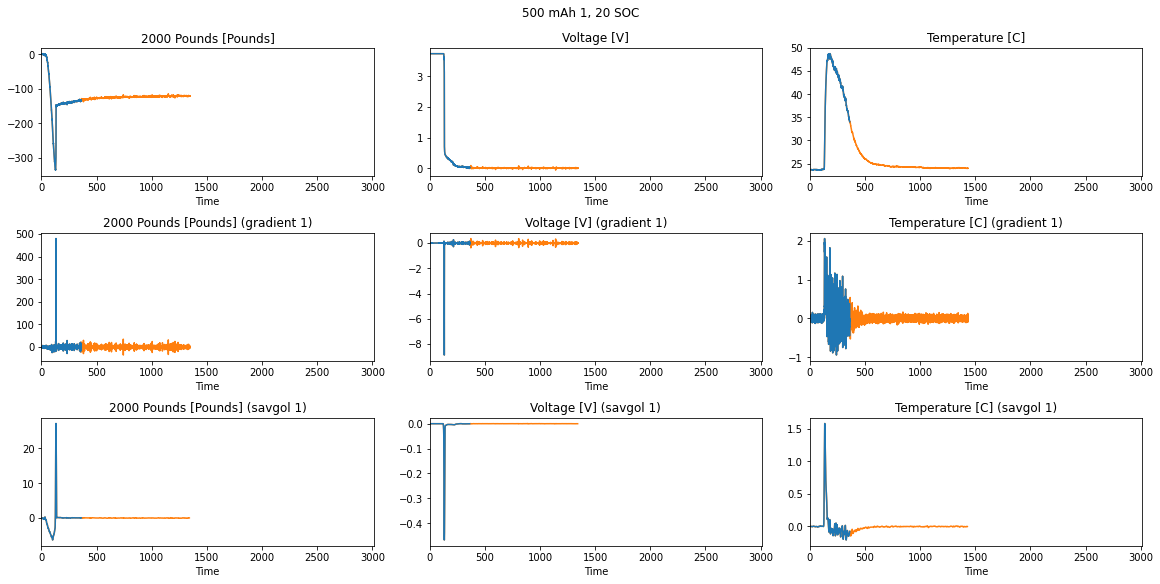

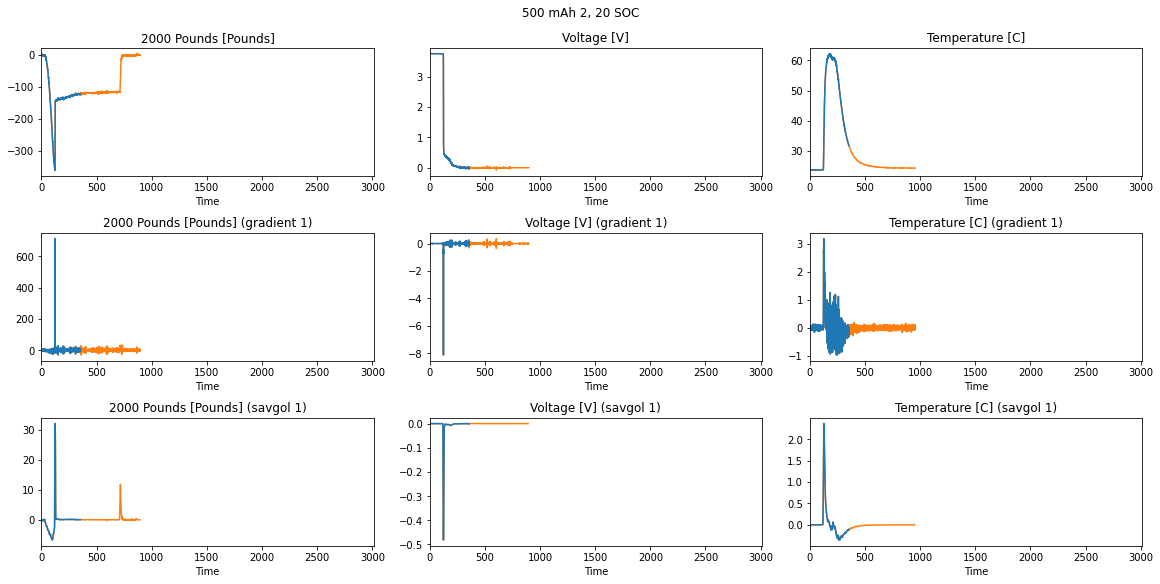

In [6]:
def get_unique(items):
    seen = set()
    unique = list()
    for item in items:
        if item not in seen:
            unique.append(item)
            seen.add(item)
    return unique        
level0 = get_unique(raw_df.columns.get_level_values(0))
level1 = get_unique(raw_df.columns.get_level_values(1))
level2 = get_unique(raw_df.columns.get_level_values(2))

for c0 in level0:
    display(HTML(f"<h1>{c0}</h1>"))
    
    if not c0.startswith("500"):
        continue
    for c1 in level1:
        display(HTML(f"<h2>{c1}</h2>"))
        if not c1.startswith("20"):
            continue
        sample_df = samples[(c0,c1)]
        
        n_cols = 3
        n_rows = int(np.ceil(len(level2)/n_cols))
#         fig = plt.figure(constrained_layout=True, figsize=(n_cols*8,5*n_rows))
        fig = plt.figure(constrained_layout=True, figsize=(16,8))
        gs = mpl.gridspec.GridSpec(
            nrows=n_rows,
            ncols=n_cols,
            figure=fig
        )
        for ii,c2 in enumerate(level2):
            ax = fig.add_subplot(gs[ii])
            ax.plot(sample_df[(c0,c1,c2)], zorder=1)
            ax.plot(raw_df[(c0,c1,c2)], zorder=0)
            ax.set_xlim(raw_df.index[0], raw_df.index[-1])
            ax.set_title(c2)
            ax.set_xlabel("Time")
        fig.suptitle("{}, {}".format(c0,c1))
        plt.show()

# Model Training

In [7]:
def train_model(samples, n_split, features, target, window, horizon, n_filters, kernel_size, hidden_dim, transfer, n_epochs, training_filter, model_id):
    model = CNN(
        window=window,
        horizon=horizon,
        n_filters=n_filters,
        kernel_size=kernel_size,
        hidden_dim=hidden_dim,
        transfer="relu",
        n_epochs=n_epochs,
        batch_learning=False,
        batch_size=32,
        shuffle=True,
        compute_device="cpu",
        parallel=False,
        verbose=1,
    )

    samples_items = np.empty(shape=len(samples), dtype=object)
    samples_items[:] = list(samples.items())

    splitter = sklearn.model_selection.LeaveOneOut()
    splits = list(splitter.split(samples_items))
    train_idx,test_idx = splits[n_split]

    XX = [
        value.loc[:,pd.IndexSlice[:,:,features]].values
        for key,value in samples_items[train_idx] 
    ]
    yy = [
        value.loc[:,pd.IndexSlice[:,:,target]].values
        for key,value in samples_items[train_idx] 
    ]
    if training_filter == "savgol":
        filter_function = lambda x:scipy.signal.savgol_filter(
            x,
            window_length=99,
            polyorder=2
        )
    elif training_filter == "isotonic_regression":
        filter_function = lambda x:np.hstack([
            sklearn.isotonic.isotonic_regression(x[:np.argmax(x)], increasing=True) if np.argmax(x) > 0 else [],
            sklearn.isotonic.isotonic_regression(x[np.argmax(x):], increasing=False) if np.argmax(x) < len(x) else []
        ])
    elif training_filter == "none":
        filter_function = None
    else:
        raise ValueError(f"Unexpected training_filter value ({filter_function})")

    model.fit(XX, yy, filter_function=filter_function)

    print("HERE", model.n_filters, model.kernel_size)
    filename = os.path.join(
        ba_utils.get_cnn_dirname([key for key,value in samples_items[test_idx]]),
        ba_utils.get_cnn_basename(features, model.window, model.horizon, model.n_filters, model.kernel_size, model.hidden_dim, model.transfer, model.n_epochs, training_filter, model_id)
    ).replace("joblib", "npz")

    keys = list(map(ba_utils.sanitize_holdout_name, samples.keys()))
    values = list(map(
        np.squeeze,
        model.transform(
            list(map(
                lambda df:df.loc[:,pd.IndexSlice[:,:,features]].values,
                samples.values()
            ))
        )
    ))
    kwargs = dict(zip(keys,values))

    ba_utils.mkdirs(os.path.dirname(filename))
    np.savez(filename, **kwargs)

    filename = os.path.join(
        ba_utils.get_cnn_dirname([key for key,value in samples_items[test_idx]]),
        ba_utils.get_cnn_basename(features, model.window, model.horizon, model.n_filters, model.kernel_size, model.hidden_dim, model.transfer, model.n_epochs, training_filter, model_id)
    )
    filename = ba_utils.save_model(filename, model)
    return model, filename

Train Epoch: 10, Loss:      157.787733
train_model 0:04:18.045288
HERE [8, 4, 2, 1] [2, 2, 2, 2]
_CNN(
  (_model): Sequential(
    (0): Conv1d(4, 8, kernel_size=(2,), stride=(1,))
    (1): Conv1d(8, 4, kernel_size=(2,), stride=(1,))
    (2): Conv1d(4, 2, kernel_size=(2,), stride=(1,))
    (3): Conv1d(2, 1, kernel_size=(2,), stride=(1,))
    (4): View(shape=(-1, 146))
    (5): Linear(in_features=146, out_features=32, bias=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=32, out_features=32, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)


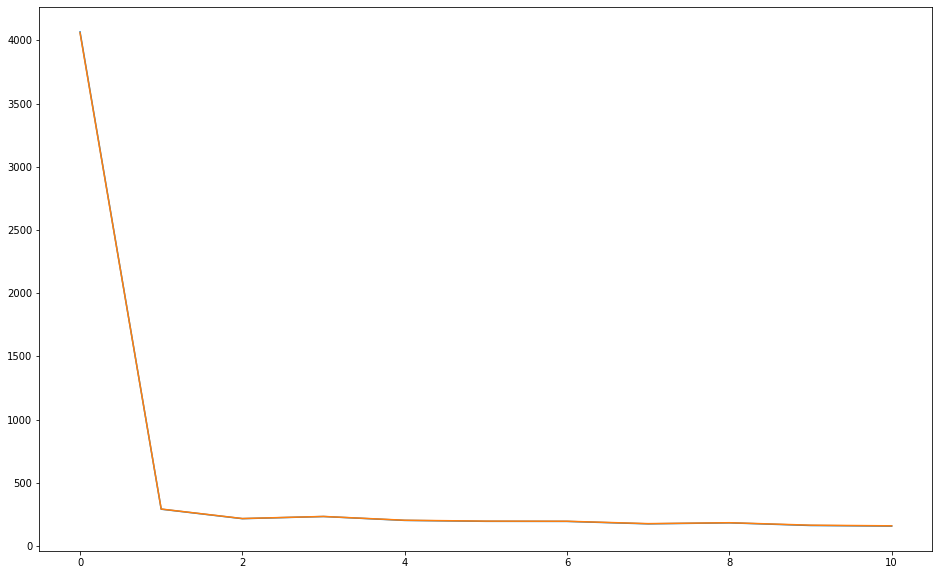

Train Epoch: 10, Loss:      166.235089
train_model 0:04:21.888107
HERE [8, 4, 2, 1] [2, 2, 2, 2]
_CNN(
  (_model): Sequential(
    (0): Conv1d(4, 8, kernel_size=(2,), stride=(1,))
    (1): Conv1d(8, 4, kernel_size=(2,), stride=(1,))
    (2): Conv1d(4, 2, kernel_size=(2,), stride=(1,))
    (3): Conv1d(2, 1, kernel_size=(2,), stride=(1,))
    (4): View(shape=(-1, 146))
    (5): Linear(in_features=146, out_features=32, bias=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=32, out_features=32, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)


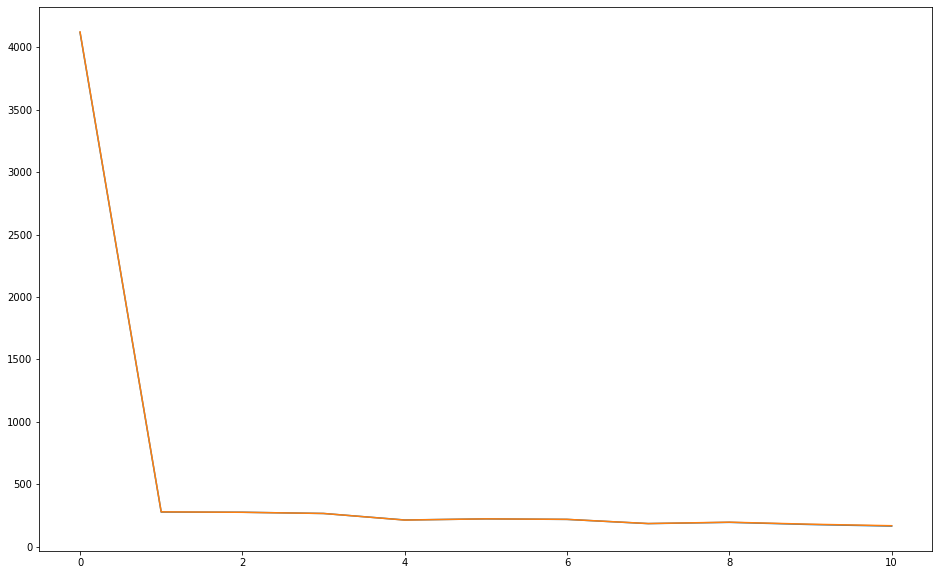

Train Epoch: 10, Loss:      166.560525
train_model 0:04:15.913813
HERE [8, 4, 2, 1] [2, 2, 2, 2]
_CNN(
  (_model): Sequential(
    (0): Conv1d(4, 8, kernel_size=(2,), stride=(1,))
    (1): Conv1d(8, 4, kernel_size=(2,), stride=(1,))
    (2): Conv1d(4, 2, kernel_size=(2,), stride=(1,))
    (3): Conv1d(2, 1, kernel_size=(2,), stride=(1,))
    (4): View(shape=(-1, 146))
    (5): Linear(in_features=146, out_features=32, bias=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=32, out_features=32, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)


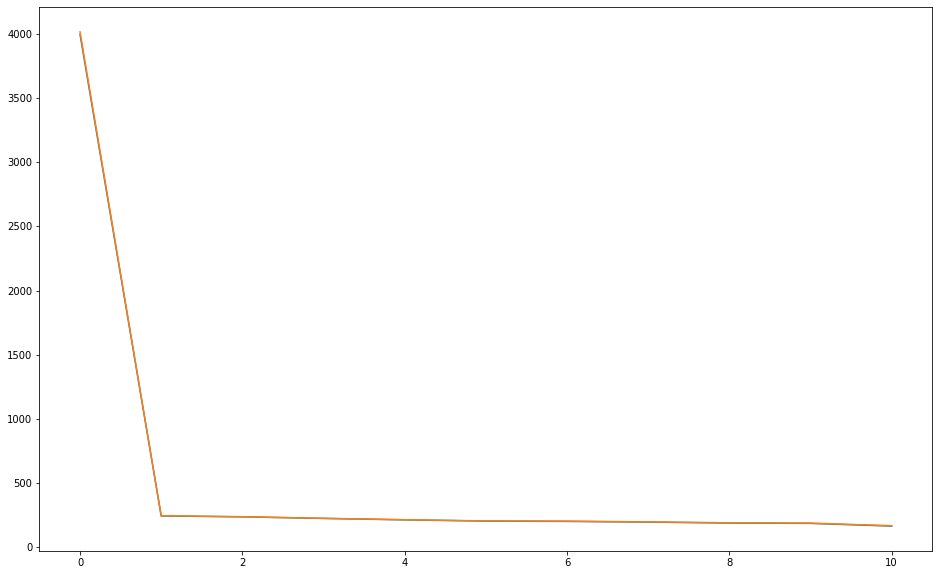

Train Epoch: 10, Loss:      146.099049
train_model 0:04:21.014455
HERE [8, 4, 2, 1] [2, 2, 2, 2]
_CNN(
  (_model): Sequential(
    (0): Conv1d(4, 8, kernel_size=(2,), stride=(1,))
    (1): Conv1d(8, 4, kernel_size=(2,), stride=(1,))
    (2): Conv1d(4, 2, kernel_size=(2,), stride=(1,))
    (3): Conv1d(2, 1, kernel_size=(2,), stride=(1,))
    (4): View(shape=(-1, 146))
    (5): Linear(in_features=146, out_features=32, bias=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=32, out_features=32, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)


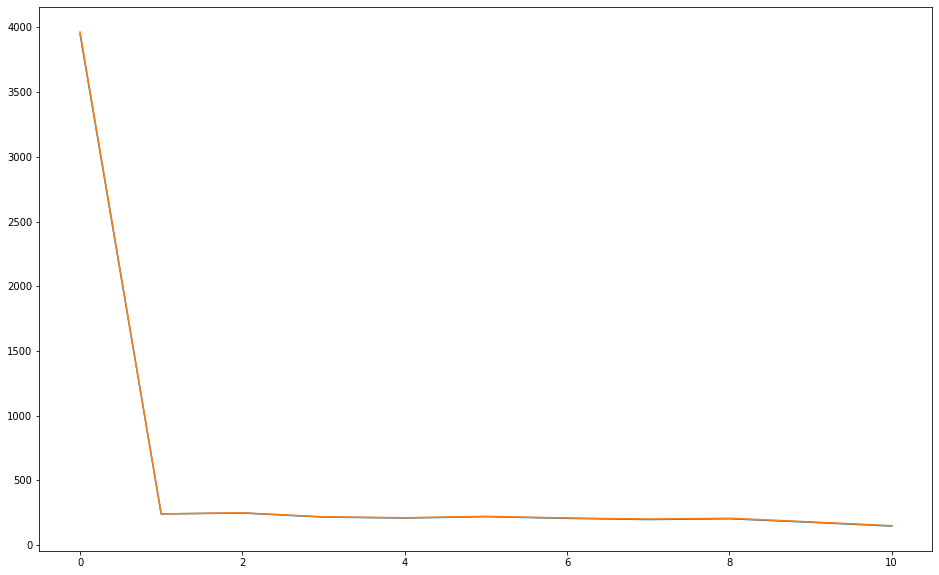

Train Epoch: 10, Loss:      164.295455
train_model 0:04:15.467502
HERE [8, 4, 2, 1] [2, 2, 2, 2]
_CNN(
  (_model): Sequential(
    (0): Conv1d(4, 8, kernel_size=(2,), stride=(1,))
    (1): Conv1d(8, 4, kernel_size=(2,), stride=(1,))
    (2): Conv1d(4, 2, kernel_size=(2,), stride=(1,))
    (3): Conv1d(2, 1, kernel_size=(2,), stride=(1,))
    (4): View(shape=(-1, 146))
    (5): Linear(in_features=146, out_features=32, bias=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=32, out_features=32, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)


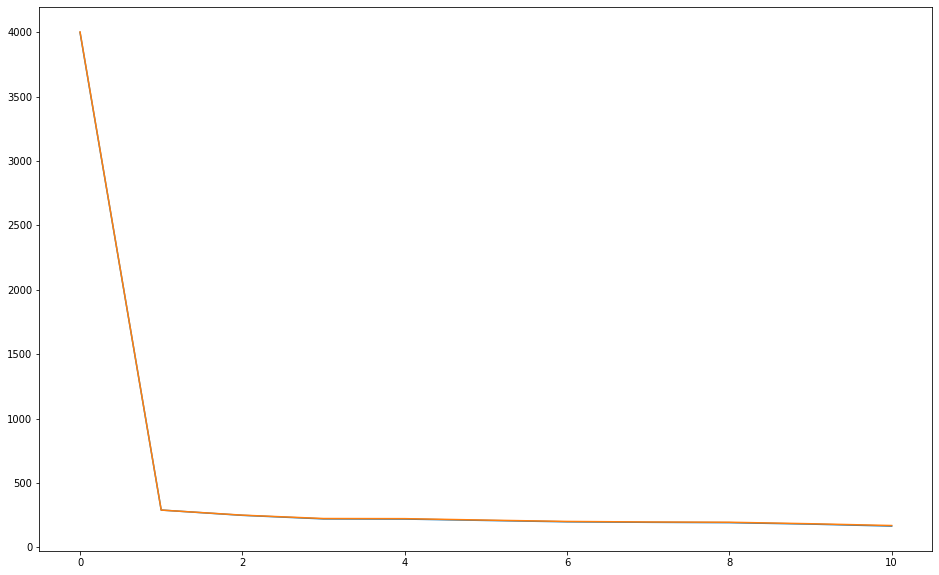

In [ ]:
for model_id in range(1,n_models+1):
    for n_filters in n_filters_list:
        for kernel_size in kernel_sizes:
            for training_filter in training_filters:
                for hidden_dim in hidden_dims:
                    for transfer in transfers:
                        for n_split in range(len(samples)):
                            model,_ = train_model(
                                samples=samples,
                                n_split=n_split,
                                features=features,
                                target=target,
                                window=window,
                                horizon=horizon,
                                n_filters=n_filters,
                                kernel_size=kernel_size,
                                hidden_dim=hidden_dim,
                                transfer=transfer,
                                n_epochs=n_epochs,
                                training_filter=training_filter,
                                model_id=model_id
                            )
                            print(model._model)
                            ba_utils.display_loss_curve(model)